In [ ]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import tensorflow as tf


In [ ]:
# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the dataset
])

In [ ]:
# Load CIFAR-100 dataset
# Use torchvision.datasets.CIFAR100 to load the training and test sets
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100%|██████████| 169M/169M [00:04<00:00, 34.7MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # CNN layers (Conv2D, MaxPool, Fully Connected)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*8*8, 512)
        self.fc2 = nn.Linear(512, 100)  # Output layer for 10 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First conv layer + relu activation + pool
        x = self.pool(torch.relu(self.conv2(x)))  # Second conv layer + relu activation + pool
        x = x.view(-1, 64*8*8)  # Flattened the tensor
        x = torch.relu(self.fc1(x))  # Fully connected layer + relu activation
        x = self.fc2(x)  # Output layer
        return x


In [ ]:
# Initialize the CNN model, loss function, and optimizer
model_cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 5
ls_losses = []
ls_accuracies = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model_cnn(images)  # forward pass through the CNN
        loss = criterion(outputs, labels) # find error between labels and outputs
        ls_losses.append(loss.detach().numpy())
        _, predicted = torch.max(outputs.data, 1)
        ls_accuracies.append(accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy()))


        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [100/782], Loss: 1.3385
Epoch [1/5], Step [200/782], Loss: 1.5190
Epoch [1/5], Step [300/782], Loss: 1.5467
Epoch [1/5], Step [400/782], Loss: 1.5970
Epoch [1/5], Step [500/782], Loss: 1.6767
Epoch [1/5], Step [600/782], Loss: 1.6829
Epoch [1/5], Step [700/782], Loss: 1.2650
Epoch [2/5], Step [100/782], Loss: 0.7812
Epoch [2/5], Step [200/782], Loss: 0.8776
Epoch [2/5], Step [300/782], Loss: 1.2382
Epoch [2/5], Step [400/782], Loss: 1.2817
Epoch [2/5], Step [500/782], Loss: 0.8807
Epoch [2/5], Step [600/782], Loss: 1.0784
Epoch [2/5], Step [700/782], Loss: 1.1589
Epoch [3/5], Step [100/782], Loss: 0.8124
Epoch [3/5], Step [200/782], Loss: 0.6626
Epoch [3/5], Step [300/782], Loss: 0.8499
Epoch [3/5], Step [400/782], Loss: 1.3424
Epoch [3/5], Step [500/782], Loss: 0.9606
Epoch [3/5], Step [600/782], Loss: 0.8483
Epoch [3/5], Step [700/782], Loss: 1.4094
Epoch [4/5], Step [100/782], Loss: 0.3870
Epoch [4/5], Step [200/782], Loss: 0.4129
Epoch [4/5], Step [300/782], Loss:

In [ ]:
# Test the CNN model
model_cnn.eval()
all_preds_cnn = []
all_labels_cnn = []

with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_cnn(images)  #with forward pass through the CNN
        _, predicted = torch.max(outputs.data, 1)
        all_preds_cnn.extend(predicted.cpu().numpy())
        all_labels_cnn.extend(labels.cpu().numpy())

# Calculate accuracy, precision, recall, and F1-score for the CNN
accuracy_cnn = accuracy_score(all_labels_cnn, all_preds_cnn)
precision_cnn = precision_score(all_labels_cnn, all_preds_cnn, average='weighted')
recall_cnn = recall_score(all_labels_cnn, all_preds_cnn, average='weighted')
f1_cnn = f1_score(all_labels_cnn, all_preds_cnn, average='weighted')

print(f"CNN Accuracy: {accuracy_cnn:.4f}")
print(f"CNN Precision: {precision_cnn:.4f}")
print(f"CNN Recall: {recall_cnn:.4f}")
print(f"CNN F1-Score: {f1_cnn:.4f}")


CNN Accuracy: 0.8855
CNN Precision: 0.8939
CNN Recall: 0.8855
CNN F1-Score: 0.8853


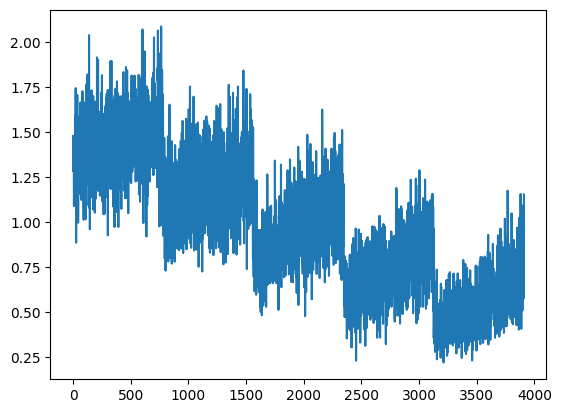

In [ ]:
# Plot Losses
x_axis = np.arange(0, len(ls_losses), 1)
plt.plot(x_axis, ls_losses)
plt.xlabel = "Sample"
plt.ylabel = "Loss"

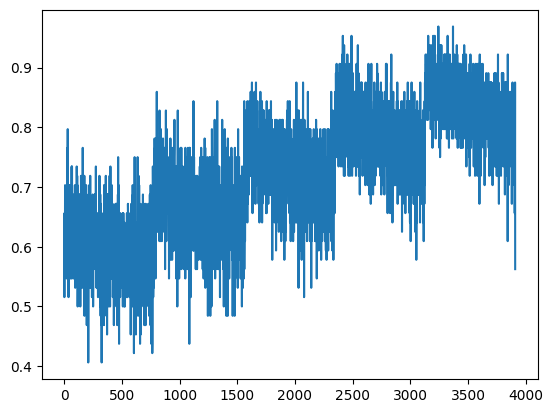

In [ ]:
# Plot Accuracy
x_axis = np.arange(0, len(ls_accuracies), 1)
plt.plot(x_axis, ls_accuracies)
plt.xlabel = "Sample"
plt.ylabel = "Accuracy"